# Exploratory Data Analysis of Weather in Illinois

In [31]:
from pathlib import Path # Library used for handling paths
import pandas as pd # DataFrame library
import numpy as np # Array library
import matplotlib.pyplot as plt # Plotting library
import os # operating system module used for storing credentials into the environment variable
plt.style.use('default') # Ensures that my plots are made using a whitebackground.

### The data was extracted from the NOAA's Global Historical Climatology Network (GHCN) dataset. The SQL query was run in the Google BigQuery console as shown below. The resulting dataset was saved to a dataframe as shown in the next cell.

![Illinois Temperature Data (1990 - 2023).png](<attachment:Illinois Temperature Data (1990 - 2023).png>)

In [32]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(Path.cwd() / "secrets" / "my_credentials.json") # Credentials to be able to access the Google BigQuery public datasets

In [33]:
raw_temp_query = """SELECT weather.id, weather.date, weather.element, weather.value, weather.qflag, 
                       stations.latitude, stations.longitude, stations.state, stations.name 
                       FROM `bigquery-public-data.ghcn_d.ghcnd_*` AS weather
                       INNER JOIN `bigquery-public-data.ghcn_d.ghcnd_stations` AS stations
                       ON weather.id = stations.id
                       WHERE weather.id LIKE 'US%'
                       AND weather.element IN ('TMAX', 'TMIN', 'TAVG', 'TOBS')
                       AND weather.qflag IS NULL
                       AND EXTRACT(YEAR FROM weather.date) BETWEEN 1990 AND 2023
                       AND weather._TABLE_SUFFIX BETWEEN '1990' AND '2023'
                       AND stations.id LIKE 'US%'
                       AND stations.state = 'IL'; """ # This query extracts weather data from the US in Illinois from the year 1990 to 2023
raw_temp_data = pd.read_gbq(raw_temp_query, use_bqstorage_api = True, progress_bar_type = "tqdm_notebook", dialect = "standard") # Load the data from the SQL query through Google BigQuery

Downloading:   0%|          |

In [34]:
raw_temp_data.drop(["qflag", "state", "id"], axis = 1, inplace = True) # Drop the qflag, state, and id columns
raw_temp_data["date"] = pd.to_datetime(raw_temp_data["date"]) # Convert the date column from a generic object type to a datetime object
raw_temp_data["value_degF"] = 9/5 * (raw_temp_data["value"] / 10) + 32 # Turn the value column which is in tenths of a degree Celsius to Fahrenheit
raw_temp_data.sort_values(by = "date", ignore_index = True, inplace = True) # Sort the temperatures by date
raw_temp_data = raw_temp_data[["date", "name", "element", "value", "value_degF", "latitude", "longitude"]] # Reorder the columns
raw_temp_data

,date,name,element,value,value_degF,latitude,longitude
0,1990-01-01,CHICAGO MIDWAY AP 3SW,TMAX,-17.0,28.94,41.7372,-87.7775
1,1990-01-01,TISKILWA 2 SE,TMAX,6.0,33.08,41.2667,-89.4667
2,1990-01-01,OLNEY 2S,TOBS,-28.0,26.96,38.7006,-88.0819
3,1990-01-01,CHICAGO UNIV,TMIN,-22.0,28.04,41.7833,-87.6000
4,1990-01-01,GALESBURG,TMAX,-22.0,28.04,40.9464,-90.3856
...,...,...,...,...,...,...,...
4823851,2023-11-14,AURORA,TOBS,-11.0,30.02,41.7803,-88.3092
4823852,2023-11-14,MUNDELEIN 4 WSW,TOBS,-6.0,30.92,42.2553,-88.0775
4823853,2023-11-14,SHELBYVILLE DAM,TMAX,183.0,64.94,39.4078,-88.7739
4823854,2023-11-14,FAIRFIELD RADIO WFIW,TOBS,6.0,33.08,38.3806,-88.3264


In [36]:
raw_temp_data_pivot = raw_temp_data.pivot(columns = "element", values = "value_degF") # Converts the categorical data in the elements column to their own respective columns

In [37]:
transformed_temp_data = pd.concat([raw_temp_data, raw_temp_data_pivot], axis = 1) # combine the newly generated columns with the existing dataframe
transformed_temp_data.drop(["element", "value", "value_degF"], axis = 1, inplace = True) # drop the element and value columns
transformed_temp_data

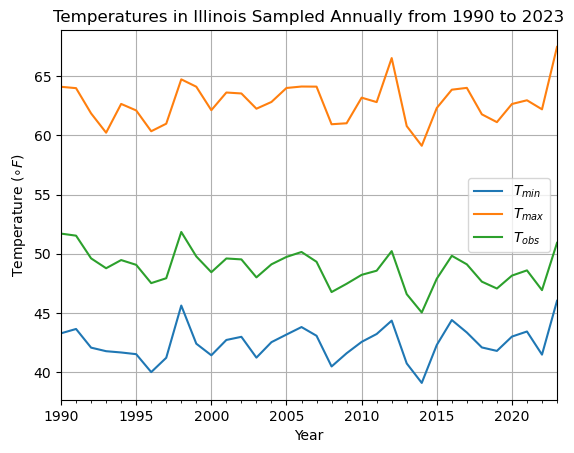

In [41]:
# This code plots the minimum, maximum, average, and observed temperatures
ax = (transformed_temp_data[["date","TMIN", "TMAX", "TOBS"]].resample("Y", on = "date").mean() # Resample the temperature dataframe over one year (originally was sampled per day)
      .plot(xlabel = "Year", ylabel = r"Temperature ($\circ F$)", grid = True, title = "Temperatures in Illinois Sampled Annually from 1990 to 2023"))
ax.legend(loc = "best", labels = [r"$T_{min}$", r"$T_{max}$", r"$T_{obs}$"]) # Format the temperature labels

In [42]:
transformed_temp_data["name"].nunique() # number of stations in Illinois

209

In [43]:
transformed_temp_data["name"].unique() # list of all the station names

array(['CHICAGO MIDWAY AP 3SW', 'TISKILWA 2 SE', 'OLNEY 2S',
       'CHICAGO UNIV', 'GALESBURG', 'MARENGO', 'EFFINGHAM 3SW',
       'CHICAGO BOTANIC GARDEN', 'HENNEPIN WTR TRMT PLT',
       'MASON CITY 4SE', 'CARBONDALE SEWAGE PLT', 'WATERLOO 6SW',
       'MORRISONVILLE', 'HAVANA', 'ROCKFORD GTR ROCKFORD AP',
       'CHARLESTON', 'MT CARROLL', 'MOWEAQUA 2S', 'CHENOA', 'DECATUR WTP',
       'FAIRFIELD RADIO WFIW', 'MT CARMEL', 'PAXTON 2 WSW',
       'DIXON SPRINGS AGRIC CTR', 'FARMER CITY 3W', 'VIRDEN', 'ELGIN',
       'MARION 4 NNE', 'FLORA 5 NW', 'WATSEKA 2NW', 'VANDALIA',
       'KANKAKEE WWTP', 'PIPER CITY', 'SPARTA 1 W', 'BROOKPORT DAM 52',
       'BELLEVILLE SIU RSCH', 'GIBSON CITY', 'CHICAGO OHARE INTL AP',
       'LA HARPE', 'JACKSONVILLE 2E', 'KEWANEE 1 E', 'DANVILLE',
       'DIXON 1W', 'JERSEYVILLE 2 SW', 'FREEPORT WASTE WTP', 'PERU',
       'CAHOKIA', 'LAKE VILLA 2NE', 'PALESTINE', 'ROSICLARE 5NW',
       'CHAMPAIGN 3S', 'ANNA 4 N', 'NORMAL 4NE', 'WHITE HALL 1 E', 'PANA',
  

In [44]:
num_obs_per_station = transformed_temp_data.filter(regex = "name|T+", axis = 1).groupby("name", as_index = False).count() # number of observations per station
num_obs_per_station

,name,TAVG,TMAX,TMIN,TOBS
0,ALBION,0,5233,5072,5047
1,ALEDO,0,11915,11892,11894
2,ALTON - MELVIN PRICE L&D,0,10633,10295,10656
3,ALTONA,0,6005,5991,5822
4,ANNA 4 N,0,8675,8720,8258
...,...,...,...,...,...
204,WAUKEGAN,0,4340,4058,3986
205,WHEATON 3 SE,0,7686,7736,6652
206,WHITE HALL 1 E,0,12197,12155,12099
207,WINCHESTER,0,5811,5782,5782


In [76]:
num_obs_per_station[num_obs_per_station["name"].str.contains("CHICAGO")] # number of observations per category where the station has the name "CHICAGO"

,name,TAVG,TMAX,TMIN,TOBS
35,CHICAGO AURORA MUNI AP,2455,9099,9096,0
36,CHICAGO BOTANIC GARDEN,0,10675,10606,10560
37,CHICAGO MIDWAY AP,2676,9672,9673,0
38,CHICAGO MIDWAY AP 3SW,0,12366,12365,12361
39,CHICAGO NORTHERLY IS,0,6480,6458,6471
40,CHICAGO OHARE INTL AP,6552,12368,12368,0
41,CHICAGO PALWAUKEE AP,2656,9897,9893,0
42,CHICAGO UNIV,0,1742,1760,1743
43,CHICAGO W CHICAGO DUPAGE AP,2653,9590,9592,0
44,CHICAGO WAUKEGAN RGNL AP,2144,8785,8771,0


In [67]:
num_obs_per_station.min() # Station with the least number of observations

name    ALBION
TAVG         0
TMAX         0
TMIN         0
TOBS         0
dtype: object

In [66]:
num_obs_per_station.max() # Station with the most number of observations

name    WINDSOR
TAVG       7498
TMAX      12368
TMIN      12368
TOBS      12361
dtype: object